In [38]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from PIL import Image # Import Pillow

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


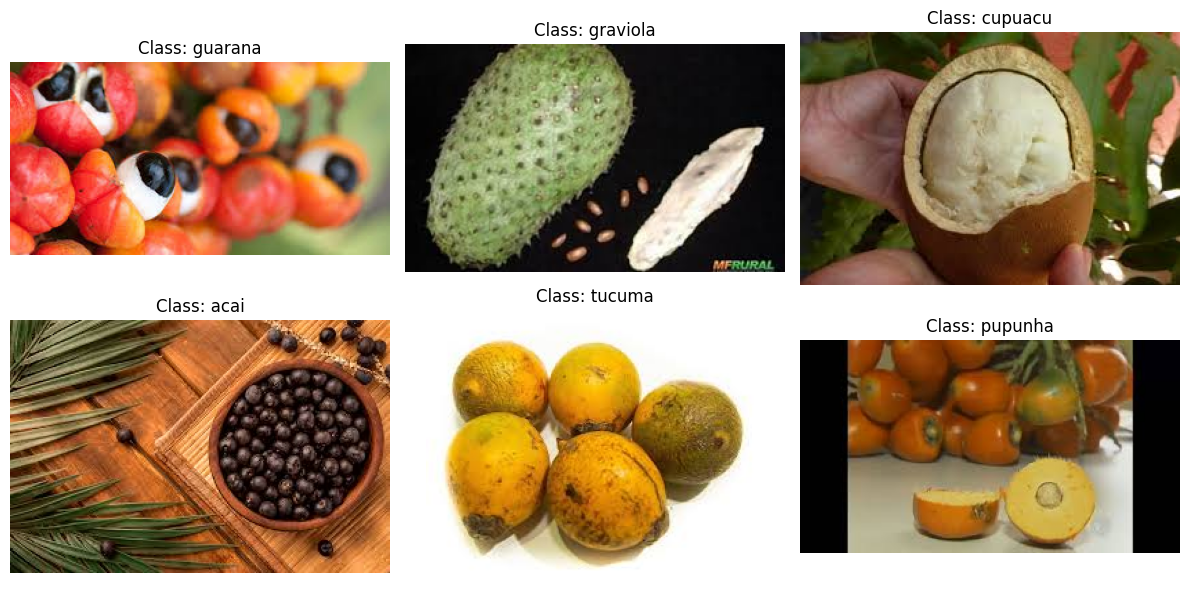

In [41]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# Define the path to the train folder
train_dir = "/content/drive/MyDrive/AI_ShivaSir/FruitinAmazon/train"
test_dir = "/content/drive/MyDrive/AI_ShivaSir/FruitinAmazon/test"

# Step 1: Get the list of class directories
class_dirs = [f for f in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, f))]
num_classes = len(class_dirs)

# Step 2: Select one image randomly from each class
selected_images = []
for class_dir in class_dirs:
    class_path = os.path.join(train_dir, class_dir)
    # Get a list of image files in the class directory
    image_files = [f for f in os.listdir(class_path) if f.endswith(('jpg', 'jpeg', 'png'))]
    # Randomly select an image
    random_image = random.choice(image_files)
    selected_images.append(os.path.join(class_path, random_image))

# Step 3: Display the images in a 2-row grid using matplotlib
# Calculate the number of columns (based on the number of images)
num_images = len(selected_images)
num_cols = (num_images + 1) // 2  # Ensure there are two rows

fig, axes = plt.subplots(2, num_cols, figsize=(12, 6))
axes = axes.flatten()  # Flatten to easily iterate over axes

for i, img_path in enumerate(selected_images):
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axes for better visualization
    axes[i].set_title(f"Class: {class_dirs[i]}")

# Turn off any unused axes if the number of images is less than the total grid slots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [42]:
# List to keep track of corrupted images
corrupted_images = []

# Step 1: Iterate through each class subdirectory
for class_dir in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_dir)

    # Only consider directories (skip non-directories)
    if os.path.isdir(class_path):
        # Step 2: Iterate through each image in the class subdirectory
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)

            # Check if the file is an image (by extension)
            if image_file.lower().endswith(('jpg', 'jpeg', 'png')):
                try:
                    # Step 3: Attempt to open the image to check its validity
                    with Image.open(image_path) as img:
                        img.verify()  # Verify the image (this doesn't load the image, only checks its validity)

                except (IOError, SyntaxError) as e:
                    # If there is an error, the image is corrupted, so remove it
                    os.remove(image_path)
                    corrupted_images.append(image_path)  # Add to the list of corrupted images
                    print(f"Removed corrupted image: {image_path}")

# Step 4: Print the result
if not corrupted_images:
    print("No corrupted images found.")


No corrupted images found.


In [43]:
import tensorflow as tf
# Define image size and batch size
img_height = 128 # Example image height
img_width = 128 # Example image width
batch_size = 32
validation_split = 0.2 # 80% training, 20% validation
# Create a preprocessing layer for normalization
rescale = tf.keras.layers.Rescaling(1./255) # Normalize pixel values to [0, 1]
# Create training dataset with normalization
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  labels="inferred",
  label_mode="int",
  image_size=(img_height, img_width),
  interpolation="nearest",
  batch_size=batch_size,
  shuffle=True,
  validation_split=validation_split,
  subset="training",
  seed=123
)
# Store class names before applying mapping
class_names = train_ds.class_names
num_classes = len(class_names)

print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")
# Apply the normalization (Rescaling) to the dataset
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
# Create validation dataset with normalization
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
train_dir,
labels="inferred",
label_mode="int",
image_size=(img_height, img_width),
interpolation="nearest",
batch_size=batch_size,
shuffle=False,
validation_split=validation_split,
subset="validation",
seed=123
)
# Apply the normalization (Rescaling) to the validation dataset
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,            # Path to the test dataset directory
    labels="inferred",   # Auto-assign labels based on subdirectory names
    label_mode="int",    # Labels as integer values
    image_size=(img_height, img_width),  # Resize images
    interpolation="nearest",
    batch_size=batch_size,
    shuffle=False        # No shuffling for test set
)

test_ds = test_ds.map(lambda x, y: (rescale(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Number of classes: 6
Found 90 files belonging to 6 classes.
Using 18 files for validation.
Found 30 files belonging to 6 classes.


In [44]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    # Convolutional Layer 1
    layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu', input_shape=(img_height, img_width, 3)),
    # Pooling Layer 1
    layers.MaxPooling2D((2, 2), strides=2),

    # Convolutional Layer 2
    layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu'),
    # Pooling Layer 2
    layers.MaxPooling2D((2, 2), strides=2),

    # Flatten Layer
    layers.Flatten(),

    # Fully Connected Network
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),

    # Output Layer
    layers.Dense(num_classes)
])

In [45]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [46]:
# Print model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
callbacks = [
  keras.callbacks.ModelCheckpoint(filepath="model_at_epoch_{epoch}.keras"),
  keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=20 ),
]
# Train the model with callbacks and validation split
history = model.fit(
  train_ds,
  batch_size=16,
  epochs=300,
  validation_data=val_ds,
  callbacks=callbacks
)

Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 816ms/step - accuracy: 0.2205 - loss: 1.8780 - val_accuracy: 0.0556 - val_loss: 1.6712
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 0.4123 - loss: 1.6566 - val_accuracy: 0.6667 - val_loss: 1.2792
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.4852 - loss: 1.3878 - val_accuracy: 0.5000 - val_loss: 1.2411
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.5742 - loss: 1.2152 - val_accuracy: 0.8333 - val_loss: 0.8265
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.7569 - loss: 0.8883 - val_accuracy: 0.5000 - val_loss: 1.4161
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.7331 - loss: 0.7612 - val_accuracy: 0.9444 - val_loss: 0.4809
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8867 - loss: 0.4669 - val_accuracy: 0.7222 - val_loss: 0.9297
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9301 - loss: 0.4097 - val_accuracy: 0.8333 - v

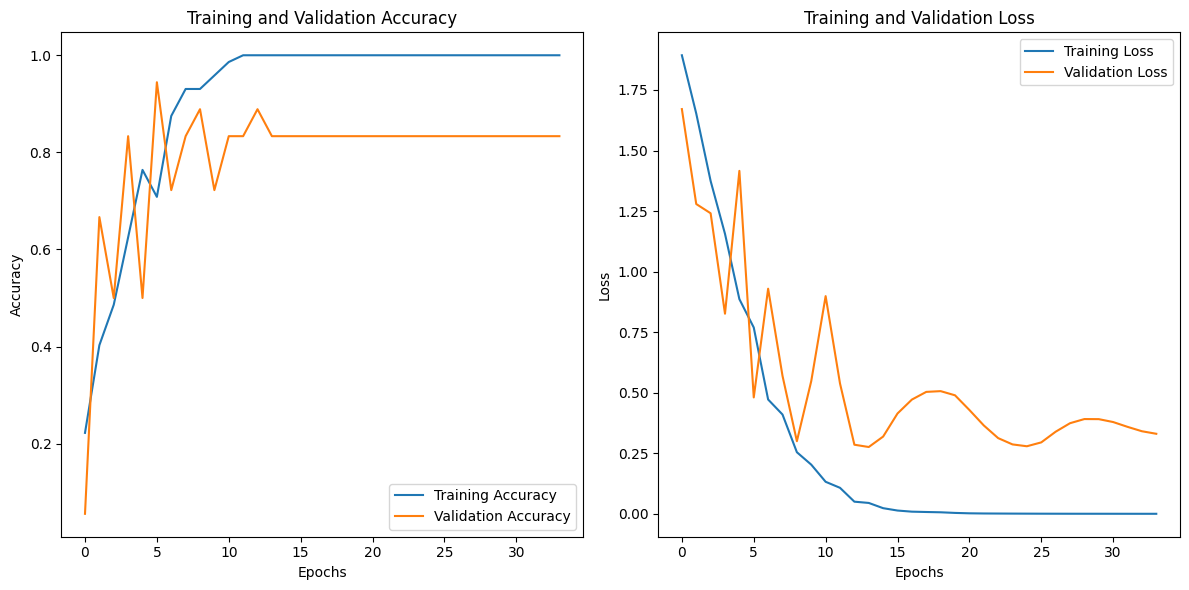

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [49]:
print("\nEvaluating model on validation set:")
test_loss, test_acc = model.evaluate(val_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")


Evaluating model on validation set:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8333 - loss: 0.2762
Test accuracy: 0.8333
Test loss: 0.2762


In [50]:
# Save the model
model.save('fruit_classification_model.h5')
print("Model saved to 'fruit_classification_model.h5'")

# Load the model
loaded_model = keras.models.load_model('fruit_classification_model.h5')
print("Model loaded successfully")

Model saved to 'fruit_classification_model.h5'
Model loaded successfully


In [51]:
import numpy as np

# Make predictions on the test dataset
predictions = model.predict(test_ds)

# Convert predictions from probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels from test_ds
true_labels = np.concatenate([y.numpy() for _, y in test_ds])  # Convert dataset labels to NumPy array

# Check the first prediction
print(f"Predicted label for first image: {predicted_labels[0]}")
print(f"True label for first image: {true_labels[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Predicted label for first image: 0
True label for first image: 0


In [52]:
from sklearn.metrics import classification_report

# Print the classification report
print("Classification Report:\n")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

        acai       0.44      0.80      0.57         5
     cupuacu       0.60      0.60      0.60         5
    graviola       0.71      1.00      0.83         5
     guarana       1.00      0.40      0.57         5
     pupunha       0.83      1.00      0.91         5
      tucuma       1.00      0.20      0.33         5

    accuracy                           0.67        30
   macro avg       0.77      0.67      0.64        30
weighted avg       0.77      0.67      0.64        30

